# W207 Group Project - What's Cooking?

Group members: Daniel Volk, Aaron Yuen

Kaggle competition link: https://www.kaggle.com/c/whats-cooking

## Business Understanding

#### Description from Kaggle:

Picture yourself strolling through your local, open-air market... What do you see? What do you smell? What will you make for dinner tonight?

If you're in Northern California, you'll be walking past the inevitable bushels of leafy greens, spiked with dark purple kale and the bright pinks and yellows of chard. Across the world in South Korea, mounds of bright red kimchi greet you, while the smell of the sea draws your attention to squids squirming nearby. India’s market is perhaps the most colorful, awash in the rich hues and aromas of dozens of spices: turmeric, star anise, poppy seeds, and garam masala as far as the eye can see.

Some of our strongest geographic and cultural associations are tied to a region's local foods. This playground competitions asks you to predict the category of a dish's cuisine given a list of its ingredients. 

#### What problem are we trying to solve?

The problem at hand is to categorize the cuisine of a recipe based on the provided list of ingredients. This competition was hosted by Yummly, a company that builds a mobile app and website that provides recipe recommendations personalized to the individual's tastes. This is a multi-class classification problem where the input is a list of strings (ingredients) and the output we are trying to predict is one of the various classes of cuisine. 

#### What are the relevant metrics?

In this classification problem, there are a few relevant metrics we will explore:
1. Accuracy
2. Precision
3. Recall

#### How do we plan to improve these metrics?

We will start by establishing a baseline using a very simple classifier with little parameter tuning and feature engineering.  Once we have established a baseline, we will then build upon it with trying various models, tuning various hyper-parameters, and spend considerable effects in feature engineering. We will also iterate through error analysis, which will also be shared in this deliverable as well.

MORE HERE ON SPECIFIC TECHNIQUES WE WILL TRY

#### What will we deliver?

The main deliverable is this iPython notebook that completes the full end-to-end project from problem scope, data understanding, exploratory analysis, baseline model, feature engineering, error analysis and final results.

## Data Understanding

#### Library Imports

In [435]:
# Loading all relevant libraries
%matplotlib inline

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
import seaborn as sn
sn.set()

matplotlib.rc('font', **{'weight' : 'bold', 'size':10} )

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, precision_score, recall_score
from sklearn import svm
from sklearn.utils import resample
from xgboost import XGBClassifier
import string
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import GridSearchCV

from sklearn.decomposition import PCA

#### Data Loading

The provided sources of data from the competition are:

1. train.json - Includes both the list of ingredients as features and the cuisine as the class
2. test.json - Includes only the list of ingredients as features. The cuisine (e.g. the class) is not present.


In [40]:
# Read train and test dataset from the provided JSONs
train = pd.read_json("data/train.json")
test = pd.read_json("data/test.json")

# Separate to raw features dataframe
X_train_all = train["ingredients"]
X_test = test["ingredients"]

# Separate label dataframe
y_train_all = train["cuisine"]

In [41]:
print X_train_all.shape
print y_train_all.shape

(39774,)
(39774,)


#### Example features and labels

In [42]:
print "First 10 example features from the training set"
print X_train_all.head(10)
print ""

print "First 10 example labels from the training set"
print y_train_all.head(10)
print ""

print "First 10 example features from the test set"
print X_test.head(10)
print ""

First 10 example features from the training set
0    [romaine lettuce, black olives, grape tomatoes...
1    [plain flour, ground pepper, salt, tomatoes, g...
2    [eggs, pepper, salt, mayonaise, cooking oil, g...
3                  [water, vegetable oil, wheat, salt]
4    [black pepper, shallots, cornflour, cayenne pe...
5    [plain flour, sugar, butter, eggs, fresh ginge...
6    [olive oil, salt, medium shrimp, pepper, garli...
7    [sugar, pistachio nuts, white almond bark, flo...
8    [olive oil, purple onion, fresh pineapple, por...
9    [chopped tomatoes, fresh basil, garlic, extra-...
Name: ingredients, dtype: object

First 10 example labels from the training set
0          greek
1    southern_us
2       filipino
3         indian
4         indian
5       jamaican
6        spanish
7        italian
8        mexican
9        italian
Name: cuisine, dtype: object

First 10 example features from the test set
0    [baking powder, eggs, all-purpose flour, raisi...
1    [sugar, egg yolks,

In [43]:
# Check for nulls in the ingredients column
(X_train_all.isnull()).sum()

0

#### Distribution of training classes

Here we can see that there is a high imbalance of classes, with majority of the cuisine to be Italian, Mexican, and Southern US. We'll need to ensure in the data preparation step that these are more balanced before training.

Text(0.5,0,u'Number of examples')

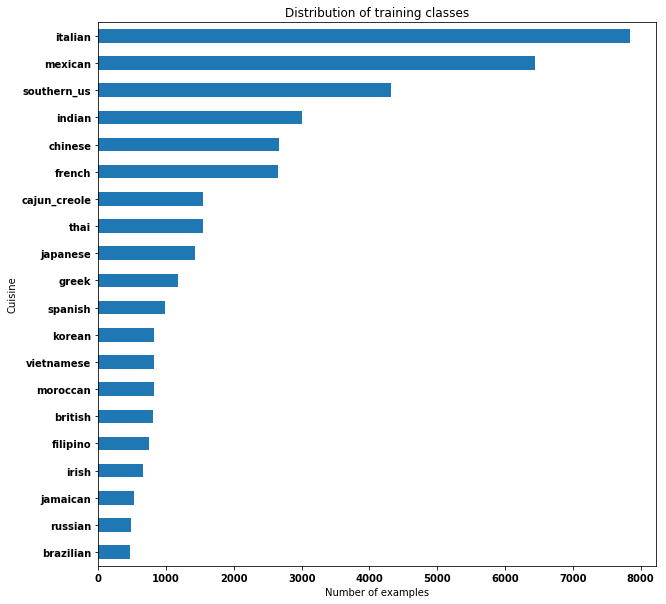

In [44]:
# Plot distribution of training classes
plt.figure(figsize=(10,10))
f = y_values = y_train_all.value_counts().plot(kind='barh')
f.invert_yaxis()
plt.title("Distribution of training classes")
plt.ylabel("Cuisine")
plt.xlabel("Number of examples")

#### Number of Ingredients per Recipe

Text(0.5,0,u'Ingredients per recipe')

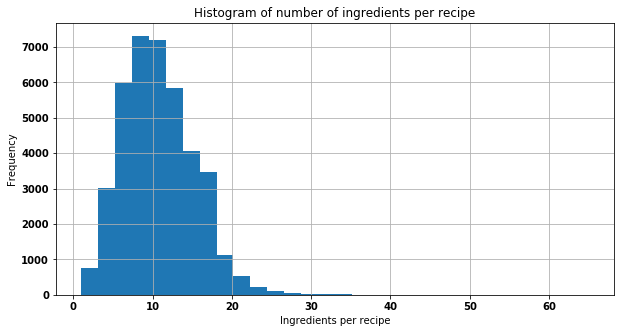

In [45]:
plt.figure(figsize=(10,5))
f = X_train_all.apply(len).hist(bins=30)
plt.title("Histogram of number of ingredients per recipe")
plt.ylabel("Frequency")
plt.xlabel("Ingredients per recipe")

#### Top Ingredients - Across All Cuisines

The top ingredients seem to be very common ingredients like salt, sugar, oil, etc. which may not be cusine-specific. These features could potentially be ruled out (or let the model feature-select). Here we can also see that there are similar ingredients that should be deduplicated (e.g. kosher salt and salt, olive oil and oil). 

In [46]:
# For each row, go through each ingredient and create a cuisine-ingredient pair
ing_cuisine_pair = []
for i in xrange(X_train_all.shape[0]):
    for ingredient in X_train_all[i]:
        ing_cuisine_pair.append([y_train_all[i], ingredient])

ing_cuisine = pandas.DataFrame(ing_cuisine_pair, columns=['cuisine', 'ingredient'])

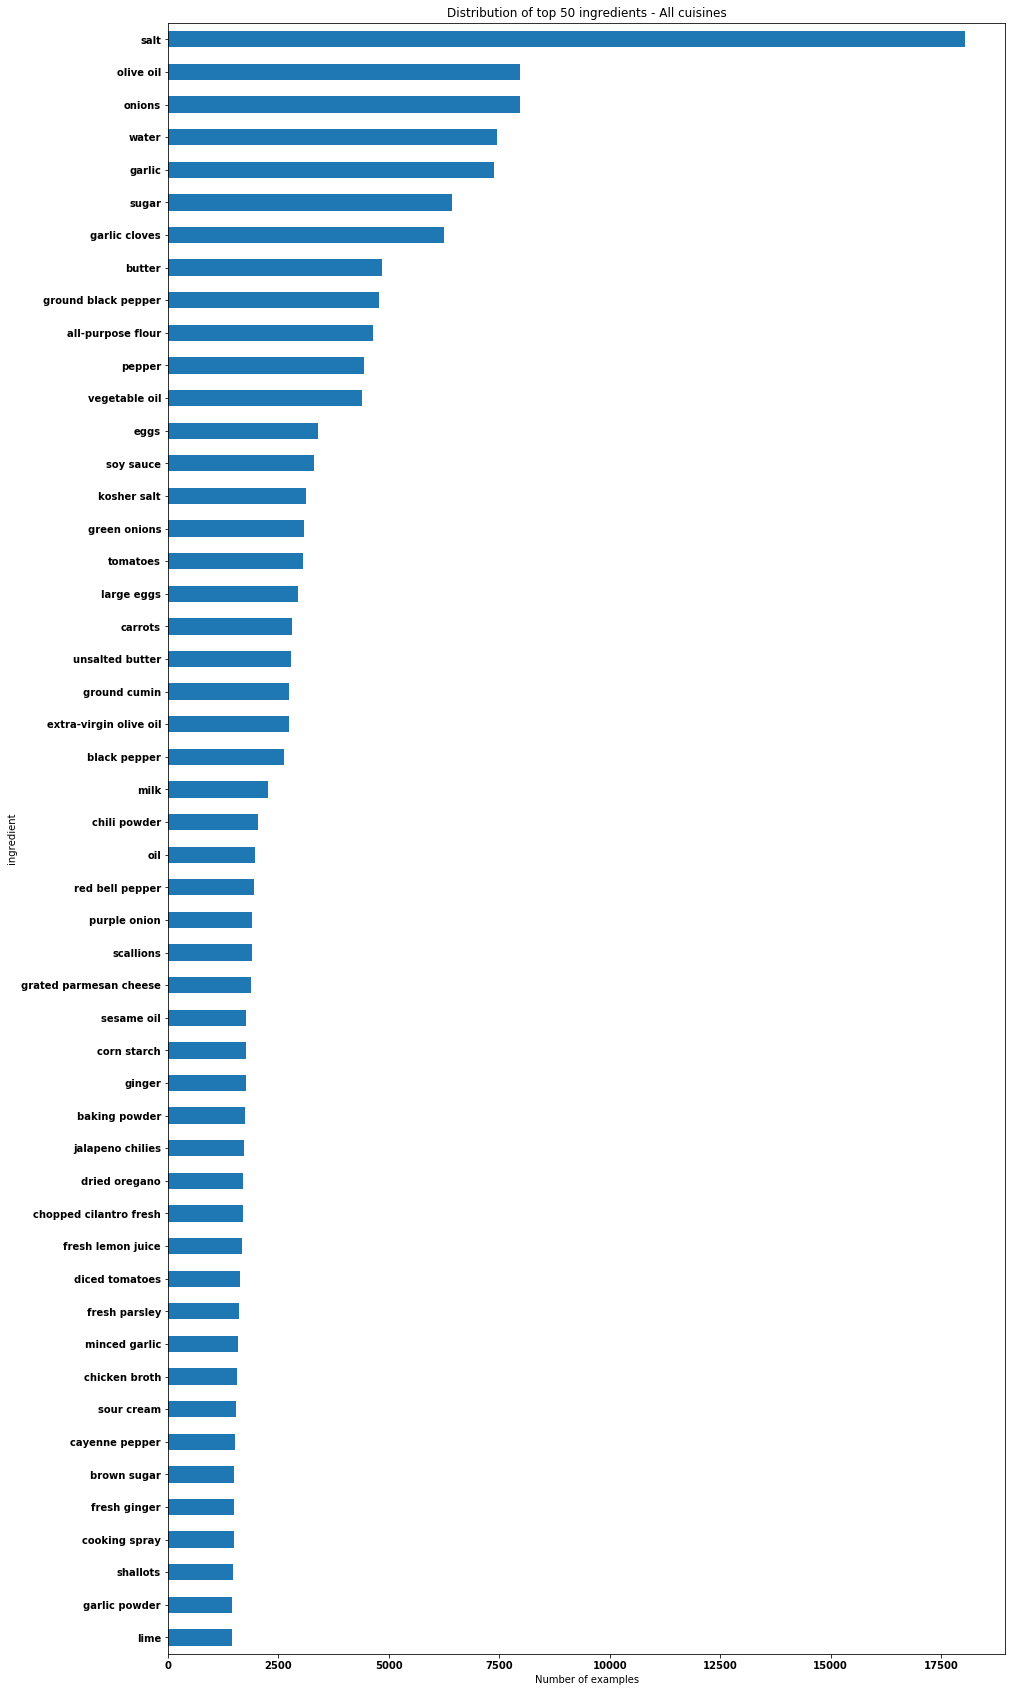

In [47]:
plt.figure(figsize=(15,30))
plt.title("Distribution of top 50 ingredients - All cuisines")
plt.ylabel("ingredient")
plt.xlabel("Number of examples")
f = ing_cuisine['ingredient'].value_counts()[:50].plot(kind='barh')
f.invert_yaxis()

#### Top Ingredients - By Cuisine

Similarly, here by cuisine the top ingredients are common ingredients like salt, but we start to see some cuisine-specific incredients like jalapeno chilies for Mexican and soy sauce for Chinese.

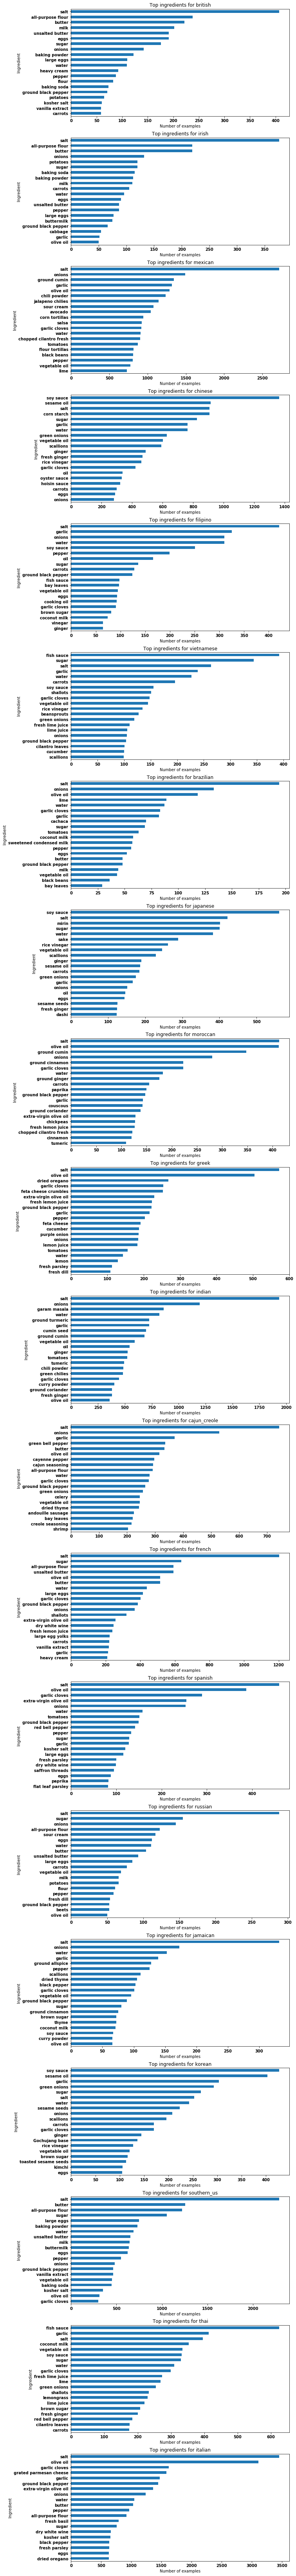

In [48]:
# Top ingredients by cuisine
plt.figure(figsize=(10,120))

grouped = ing_cuisine.groupby('cuisine')

cuisines = grouped.groups.keys()
for i in range(len(cuisines)):
    plt.subplot(20, 1, i+1)
    
    f = ing_cuisine[ing_cuisine['cuisine'] == cuisines[i]]['ingredient'].value_counts()[:20].plot(kind='barh')
    f.invert_yaxis()
    plt.title("Top ingredients for %s" % cuisines[i])
    plt.ylabel("Ingredient")
    plt.xlabel("Number of examples")
    i+=1

plt.show()

## Baseline Data Preparation

In [50]:
X_train, X_dev, y_train, y_dev = train_test_split(X_train_all, y_train_all, random_state=2)

In [51]:
print "The shape of X_train is", X_train.shape
print "The shape of X_dev is ", X_dev.shape
print "The shape of y_train is", y_train.shape
print "The shape of y_dev is", y_dev.shape

The shape of X_train is (29830,)
The shape of X_dev is  (9944,)
The shape of y_train is (29830,)
The shape of y_dev is (9944,)


In [52]:
def list_to_string(l):
    return '|'.join(l).replace(' ', '_').replace('|', ' ')

X_train_str = X_train.apply(list_to_string)
X_dev_str = X_dev.apply(list_to_string)

## Baseline Model

#### Training

For the baseline model, we are starting with a very simple logistic regression model with no hyperparameter tuning. We will also be using a very basic count vectorizer. The goal of this is really to establish a baseline and understand what the metrics are for this very basic model.

In [144]:
base_pipeline = Pipeline(steps=[
    ('countvectorizer', CountVectorizer(binary=True)),
    ('lr', LogisticRegression()),
])
base_pipeline.fit(X_train_str, y_train)

Pipeline(memory=None,
     steps=[('countvectorizer', CountVectorizer(analyzer=u'word', binary=True, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

#### Evaluation - Accuracy

Note that accuracy is NOT a good measure here especially given that there is high class imbalance. This is only calculated to establish a baseline.

In [145]:
print "Accuracy of the base model is", base_pipeline.score(X_dev_str, y_dev)

Accuracy of the base model is 0.776448109413


#### Evaluation - Precision & Recall

Precision and recall are better measures to use here with high class imbalance.

In [234]:
base_df = pd.DataFrame([X_dev_str, y_dev]).T
base_df['predicted_cuisine'] = base_pipeline.predict(base_df.ingredients)
base_df['broadmatched_ingredients'] = broadmatch_X(base_df['ingredients'])
base_df.to_csv("baseline_predictions.csv", encoding='utf-8')

In [362]:
y_pred = base_pipeline.predict(X_dev_str)
print "Precision of the base model is", precision_score(y_dev, y_pred, average='macro') 
print "Recall of the base model is", recall_score(y_dev, y_pred, average='macro') 

Precision of the base model is 0.639667108463
Recall of the base model is 0.69533702858


#### Confusion matrix

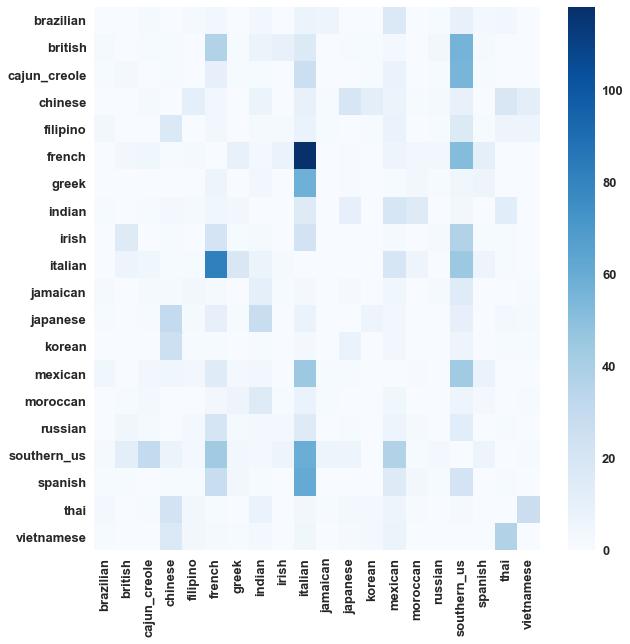

In [202]:
cm = confusion_matrix(y_dev, y_pred)
np.fill_diagonal(cm, 0)
cm_df = pandas.DataFrame(cm, index=base_pipeline.classes_, columns=base_pipeline.classes_)

plt.figure(figsize=(10,10))
sn.set(font_scale=1.3)
ax = sn.heatmap(cm_df, cmap="Blues")

#### Error Analysis

## Model with Balanced Training Classes

In [257]:
train_all = pd.DataFrame([X_train_str, y_train]).T
max_count = y_train.value_counts().max()
max_class = y_train.value_counts().idxmax()

resampled_train_all = train_all[train_all.cuisine == max_class]
for c in y_train.unique():
    if c == max_class:
        continue
        
    c_train_all = train_all[train_all.cuisine == c]
    c_train_all = resample(c_train_all, replace=True, n_samples=max_count, random_state=123)
    resampled_train_all = resampled_train_all.append(c_train_all)

resampled_train_all.cuisine.value_counts()

cajun_creole    5875
russian         5875
filipino        5875
french          5875
spanish         5875
brazilian       5875
jamaican        5875
mexican         5875
moroccan        5875
vietnamese      5875
indian          5875
korean          5875
italian         5875
irish           5875
southern_us     5875
greek           5875
british         5875
thai            5875
chinese         5875
japanese        5875
Name: cuisine, dtype: int64

In [260]:
base_pipeline = Pipeline(steps=[
    ('countvectorizer', CountVectorizer(binary=True)),
    ('lr', LogisticRegression()),
])
base_pipeline.fit(resampled_train_all.ingredients, resampled_train_all.cuisine)

Pipeline(memory=None,
     steps=[('countvectorizer', CountVectorizer(analyzer=u'word', binary=True, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [261]:
print "Accuracy of the base model is", base_pipeline.score(X_dev_str, y_dev)

Accuracy of the base model is 0.740949316171


## Baseline Model with Broadmatch

In [298]:
# Helper function for normalizing strings
def normalize(s):
    lm = WordNetLemmatizer()
    printable = string.printable
    PERMITTED_CHARS = "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ " 

    filter(lambda x: x in printable, s)
    s = "".join(c for c in s if c in PERMITTED_CHARS)
    s = lm.lemmatize(s.lower())

    return s  

In [358]:
r_X_train_all = resampled_train_all.ingredients

# For each row, go through each ingredient and create a cuisine-ingredient pair
ingredient_list = []
i = 0
for ingredients in r_X_train_all:
    for ingredient in ingredients.split(' '):
        ingredient_list.append(normalize(ingredient.replace('_', ' ')))

In [339]:
ing_counts = pd.DataFrame(ingredient_list, columns=['num_recipes']).num_recipes.value_counts()
ing_df = pd.DataFrame(ing_counts)
ing_df.index.names = ['ingredient']
ing_df.head()

,num_recipes
ingredient,
salt,54297
onion,26514
water,25301
sugar,22864
garlic,22756


In [340]:
# Given an ingredient, return all subsets of the ingredient string as a list of strings
def get_substrings(ingredient):
    # Base case - Return an empty list of the string is empty
    if ingredient == '':
        return []
    
    word_list = ingredient.split(' ')
    substring_list = []
    substring_list.append(ingredient)
    
    # Base case - Return a list with only the ingredient if there is only one word
    if len(word_list) == 1:
        return substring_list
    
    # Recursive Case    
    for i in range(len(word_list)):
        new_list = np.array(word_list, copy=True).tolist()
        new_list.remove(word_list[i])
        substring_word = ' '.join(new_list)
        substring_list.append(substring_word)
        
        sub_list = get_substrings(substring_word)
        for w in sub_list:
            substring_list.append(w)

    return substring_list

# Dedupes the output list of get_substrings function
def get_substrings_deduped(substring_list):
    return np.unique(get_substrings(substring_list)).tolist()

In [343]:
def broadmatch(ing):
    if len(ing.split(' ')) > 10:
        return ing
    
    df = pd.DataFrame(get_substrings_deduped(ing), columns=['ingredient']).set_index('ingredient')
    joined_df = df.join(ing_df, lsuffix = 'l', rsuffix='r')
    
    normalized_ingredient = joined_df['num_recipes'].idxmax()
    return normalized_ingredient if not type(normalized_ingredient) == float else ing

In [344]:
norm_ing_arr = []
for i in range(len(ing_df.index)):
    print "%d: %s --> %s" % (i, ing_df.index[i], broadmatch(ing_df.index[i]))
    norm_ing_arr.append([ing_df.index[i], broadmatch(ing_df.index[i])])

0: salt --> salt
1: onion --> onion
2: water --> water
3: sugar --> sugar
4: garlic --> garlic
5: olive oil --> olive oil
6: garlic cloves --> garlic
7: vegetable oil --> vegetable oil
8: pepper --> pepper
9: butter --> butter
10: ground black pepper --> pepper
11: soy sauce --> soy sauce
12: allpurpose flour --> allpurpose flour
13: egg --> egg
14: carrot --> carrot
15: green onions --> green onions
16: unsalted butter --> butter
17: large eggs --> large eggs
18: kosher salt --> salt
19: black pepper --> pepper
20: tomato --> tomato
21: milk --> milk
22: scallion --> scallion
23: sesame oil --> sesame oil
24: oil --> oil
25: ground cumin --> ground cumin
26: ginger --> ginger
27: extravirgin olive oil --> olive oil
28: fish sauce --> fish sauce
29: brown sugar --> sugar
30: red bell pepper --> pepper
31: baking powder --> baking powder
32: fresh ginger --> ginger
33: corn starch --> corn starch
34: potato --> potato
35: minced garlic --> garlic
36: flour --> flour
37: ground cinnamon 

290: mango --> mango
291: baking potatoes --> baking potatoes
292: half  half --> half  half
293: lean ground beef --> ground beef
294: apple cider vinegar --> vinegar
295: yellow bell pepper --> pepper
296: mustard seeds --> mustard seeds
297: juice --> juice
298: apple --> apple
299: cheese --> cheese
300: grated nutmeg --> nutmeg
301: firm tofu --> firm tofu
302: noodle --> noodle
303: dry sherry --> dry sherry
304: plain flour --> flour
305: fennel seeds --> fennel seeds
306: chile pepper --> pepper
307: parmesan cheese --> cheese
308: cornmeal --> cornmeal
309: dry red wine --> dry red wine
310: beer --> beer
311: asian fish sauce --> fish sauce
312: minced ginger --> ginger
313: beet --> beet
314: beef stock --> beef
315: serrano chile --> chile
316: lettuce leaves --> lettuce leaves
317: sweet paprika --> paprika
318: coconut --> coconut
319: chopped green bell pepper --> pepper
320: lemon wedge --> lemon
321: vegetable stock --> vegetable stock
322: pork tenderloin --> pork
323

564: tapioca flour --> flour
565: dried shrimp --> shrimp
566: phyllo dough --> phyllo dough
567: cardamom pods --> cardamom pods
568: maple syrup --> maple syrup
569: dry mustard --> mustard
570: chicken breast halves --> chicken
571: tomatillo --> tomatillo
572: corned beef --> beef
573: bean --> bean
574: stock --> stock
575: linguine --> linguine
576: fat free milk --> milk
577: mint sprigs --> mint
578: shortgrain rice --> rice
579: squid --> squid
580: pitted date --> pitted date
581: raspberry --> raspberry
582: shredded monterey jack cheese --> cheese
583: sirloin steak --> sirloin steak
584: light corn syrup --> corn
585: sugar pea --> sugar
586: ricotta cheese --> cheese
587: bird chile --> chile
588: iceberg lettuce --> lettuce
589: bittersweet chocolate --> bittersweet chocolate
590: seasoning salt --> salt
591: fresh raspberries --> fresh raspberries
592: dough --> dough
593: instant yeast --> yeast
594: chuck --> chuck
595: ground chicken --> chicken
596: shrimp paste -->

854: hamburger buns --> hamburger buns
855: mixed spice --> spice
856: swiss chard --> swiss chard
857: provolone cheese --> cheese
858: fenugreek seeds --> fenugreek seeds
859: nut --> nut
860: reduced fat milk --> milk
861: green cardamom --> cardamom
862: gari --> gari
863: glutinous rice --> rice
864: oyster --> oyster
865: dried dillweed --> dried dillweed
866: butter lettuce --> butter
867: sweet pepper --> pepper
868: egg roll wrappers --> egg
869: habanero pepper --> pepper
870: starch --> starch
871: waxy potatoes --> waxy potatoes
872: light mayonnaise --> light mayonnaise
873: fat skimmed chicken broth --> chicken broth
874: white mushrooms --> white mushrooms
875: hothouse cucumber --> cucumber
876: coarse kosher salt --> salt
877: simple syrup --> simple syrup
878: dried porcini mushrooms --> dried porcini mushrooms
879: dried bonito flakes --> dried bonito flakes
880: canned low sodium chicken broth --> chicken broth
881: chipotle chile --> chile
882: littleneck clams -->

1145: green tea --> green
1146: boneless chop pork --> pork
1147: asparagus spears --> asparagus
1148: bone in chicken thighs --> chicken
1149: baby corn --> corn
1150: pimento stuffed olives --> pimento
1151: kielbasa --> kielbasa
1152: hot dogs --> hot dogs
1153: crimini mushrooms --> crimini mushrooms
1154: pizza doughs --> pizza doughs
1155: madras curry powder --> curry powder
1156: suet --> suet
1157: sea bass fillets --> sea bass fillets
1158: fresh red chili --> chili
1159: kiwi --> kiwi
1160: low sodium beef broth --> beef broth
1161: masala --> masala
1162: salsa verde --> salsa
1163: whole kernel corn drain --> corn
1164: almond butter --> butter
1165: orange rind --> orange
1166: roasted sesame seeds --> sesame seeds
1167: artichok heart marin --> artichok heart marin
1168: safflower oil --> oil
1169: rhubarb --> rhubarb
1170: rye bread --> bread
1171: portabello mushroom --> mushroom
1172: serrano --> serrano
1173: chaat masala --> masala
1174: rotisserie chicken --> chick

1415: crema --> crema
1416: raw cashews --> raw cashews
1417: chili bean paste --> chili paste
1418: golden delicious apples --> golden delicious apples
1419: dumpling wrappers --> dumpling
1420: cane vinegar --> vinegar
1421: country bread --> bread
1422: shrimp stock --> shrimp
1423: frozen mixed berries --> frozen mixed berries
1424: nori sheets --> nori
1425: perilla --> perilla
1426: yellow miso --> miso
1427: coconut aminos --> coconut
1428: boiled eggs --> boiled eggs
1429: rosemary leaves --> rosemary
1430: sweet and sour sauce --> sauce
1431: tamarind concentrate --> tamarind
1432: bulgur --> bulgur
1433: green lentil --> lentil
1434: top sirloin --> sirloin
1435: asian eggplants --> asian eggplants
1436: cold milk --> milk
1437: sunflower seeds --> sunflower seeds
1438: mixed dried fruit --> fruit
1439: rack of lamb --> lamb
1440: white hominy --> white hominy
1441: cream sweeten whip --> cream
1442: cooked bacon --> bacon
1443: dry vermouth --> dry vermouth
1444: ear of corn

1705: pork spareribs --> pork
1706: dried beef --> beef
1707: pastry shell --> pastry
1708: sweet pickle relish --> pickle
1709: canned coconut milk --> milk
1710: whole wheat pita --> pita
1711: taro --> taro
1712: country crock spread --> country crock spread
1713: frozen mixed vegetables --> mixed vegetables
1714: low sodium vegetable broth --> vegetable broth
1715: splenda --> splenda
1716: frozen raspberries --> frozen raspberries
1717: wine vinegar --> vinegar
1718: coconut juice --> juice
1719: extra lean ground beef --> ground beef
1720: salted fish --> fish
1721: caribbean jerk seasoning --> seasoning
1722: uncook medium shrimp peel and devein --> shrimp
1723: adobo --> adobo
1724: triple sec --> triple sec
1725: amaretto --> amaretto
1726: catfish --> catfish
1727: chervil --> chervil
1728: toasted wheat germ --> toasted wheat germ
1729: corn kernel whole --> corn
1730: sparerib --> sparerib
1731: cantaloupe --> cantaloupe
1732: hot italian sausages --> hot italian sausages
1

1969: strong white bread flour --> flour
1970: chocolate morsels --> chocolate
1971: pea pods --> pea
1972: quail eggs --> quail eggs
1973: turkey breast --> turkey
1974: pita chips --> pita
1975: bartlett pears --> bartlett pears
1976: whole milk ricotta cheese --> milk
1977: refrigerated biscuits --> refrigerated biscuits
1978: squirt --> squirt
1979: green tea powder --> green
1980: pimenton --> pimenton
1981: pickled vegetables --> pickled vegetables
1982: togarashi --> togarashi
1983: nonfat plain greek yogurt --> plain yogurt
1984: pepperoni slices --> pepperoni
1985: green mango --> mango
1986: rotelle --> rotelle
1987: apple pie spice --> apple
1988: ham steak --> ham
1989: soft fresh goat cheese --> cheese
1990: custard --> custard
1991: rotel tomatoes --> rotel tomatoes
1992: bean sauce --> sauce
1993: spicy sausage --> sausage
1994: peppermint extract --> peppermint extract
1995: pepitas --> pepitas
1996: canola mayonnaise --> canola
1997: dende oil --> oil
1998: flora cuisi

2217: vegan margarine --> margarine
2218: arbol chile --> chile
2219: cream cheese frosting --> cream cheese
2220: fideos --> fideos
2221: garlic bulb --> garlic
2222: cola --> cola
2223: garlic oil --> garlic
2224: smoked ham --> ham
2225: adzuki beans --> adzuki beans
2226: pickled jalapeno peppers --> pickled jalapeno peppers
2227: reduced fat firm tofu --> firm tofu
2228: green tea bags --> green
2229: split black lentils --> split black lentils
2230: chocolate shavings --> chocolate
2231: pickled radish --> radish
2232: nonfat milk --> milk
2233: silver --> silver
2234: foot --> foot
2235: hot chili oil --> oil
2236: foie gras --> foie gras
2237: piecrust --> piecrust
2238: european cucumber --> cucumber
2239: zinfandel --> zinfandel
2240: chinese wheat noodles --> chinese noodles
2241: orecchiette --> orecchiette
2242: pork stock --> pork
2243: broad beans --> broad beans
2244: distilled vinegar --> vinegar
2245: pumpernickel bread --> bread
2246: oldfashioned oatmeal --> oatmeal

2495: vanilla wafer crumbs --> vanilla
2496: cream of celery soup --> celery
2497: sweet basil --> basil
2498: steamer --> steamer
2499: smoked  dried fish --> fish
2500: shortbread cookies --> shortbread cookies
2501:  up -->  up
2502: burger --> burger
2503: lavender --> lavender
2504: loin --> loin
2505: ravva --> ravva
2506: olive oil spray --> olive oil
2507: emerils original essence --> essence
2508: black mission figs --> mission figs
2509: toor dal --> dal
2510: brazil nuts --> brazil nuts
2511: calimyrna figs --> calimyrna figs
2512: pork fillet --> pork
2513: tamarind extract --> tamarind
2514: firm silken tofu --> firm tofu
2515: sliced apples --> sliced apples
2516: peach schnapps --> peach
2517: ground sausage --> sausage
2518: and fat free half half --> fat
2519: shank --> shank
2520: andouille chicken sausage --> chicken
2521: refrigerated buttermilk biscuits --> buttermilk
2522: tandoori spices --> tandoori spices
2523: barley flour --> flour
2524: radish sprouts --> ra

2752: diced chicken --> chicken
2753: red bell pepper sliced --> pepper
2754: rib pork chops --> pork
2755: marjoram leaves --> marjoram
2756: dried dates --> dried dates
2757: pork bouillon cube --> pork
2758: extra virgin coconut oil --> oil
2759: knorr chicken flavor bouillon --> chicken
2760: annatto powder --> annatto
2761: giardiniera --> giardiniera
2762: tapioca pearls --> tapioca
2763: whole nutmegs --> whole nutmegs
2764: green apples --> green
2765: marrow bones --> marrow bones
2766: bee pollen --> bee pollen
2767: light red kidney beans --> kidney beans
2768: veal stock --> stock
2769: protein powder --> protein powder
2770: medium tomatoes --> medium tomatoes
2771: mini cucumbers --> mini cucumbers
2772: white kidney beans --> kidney beans
2773: london broil --> london broil
2774: fresh fava bean --> bean
2775: sangria --> sangria
2776: meatball --> meatball
2777: whole okra --> okra
2778: trout --> trout
2779: pomelo --> pomelo
2780: tvp --> tvp
2781: dry milk powder -->

3053: split peas --> split peas
3054: chapati flour --> flour
3055: snip fresh dill --> fresh dill
3056: frozen mango --> mango
3057: sandwich --> sandwich
3058: sichuanese chili paste --> chili paste
3059: dry rub --> rub
3060: halibut steak --> steak
3061: dried beans --> dried beans
3062: chocolate candy --> chocolate
3063: whole grain bread --> bread
3064: fresh chili --> chili
3065: sazon goya with coriander and annatto --> coriander
3066: satsuma orange --> orange
3067: shoulder lamb chops --> lamb
3068: milk chocolate pieces --> milk
3069: breadfruit --> breadfruit
3070: spelt flour --> flour
3071: knorr leek recip mix --> leek
3072: instant chicken bouillon --> chicken
3073: anise powder --> anise
3074: pizza seasoning --> seasoning
3075: fresh tuna steaks --> tuna
3076: dried plum --> plum
3077: dinner rolls --> dinner rolls
3078: frying oil --> oil
3079: roasted almonds --> roasted almonds
3080: snapper fillets --> snapper
3081: frogs legs --> frogs legs
3082: candied ginger 

3329: truffle salt --> salt
3330: kerrygold pure irish butter --> butter
3331: cornstarch noodles --> cornstarch noodles
3332: sanding sugar --> sugar
3333: raspberry liqueur --> raspberry
3334: cold cut --> cold cut
3335: top loin --> loin
3336: roasted chestnuts --> roasted chestnuts
3337: low fat mozzarella --> fat
3338: reduced fat chunky peanut butter --> butter
3339: french bread loaves --> french bread
3340: guinness lager --> lager
3341: spring roll skins --> roll
3342: cipollini --> cipollini
3343: empanada --> empanada
3344: jerk rub seasoning --> seasoning
3345: stewing steak --> steak
3346: grit quick --> grit
3347: chiffonade --> chiffonade
3348: cantal --> cantal
3349: sliced olives --> sliced olives
3350: sliced fresh fruit --> fruit
3351: butterflied leg of lamb --> leg of lamb
3352: eating apple --> apple
3353: saffron road vegetable broth --> vegetable broth
3354: raw tiger prawn --> prawn
3355: goose fat --> fat
3356: manzanilla --> manzanilla
3357: sobrasada --> sob

3617: wheat bread --> bread
3618: amberjack fillet --> fillet
3619: fruitcake --> fruitcake
3620: pink salmon --> salmon
3621: linguini --> linguini
3622: soup bones --> soup
3623: veal for stew --> veal
3624: membrillo --> membrillo
3625: porterhouse steaks --> porterhouse steaks
3626: kalamata olive halves --> kalamata
3627: fines herbes --> fines herbes
3628: mulato chiles --> mulato chiles
3629: karashi --> karashi
3630: ginger syrup --> ginger
3631: light tuna packed in olive oil --> olive oil
3632: colmans mustard powder --> mustard
3633: garnish --> garnish
3634: peasant bread --> bread
3635: pointed peppers --> pointed peppers
3636: puy lentils --> puy lentils
3637: baby leaf lettuce --> leaf
3638: pot stickers --> pot stickers
3639: italian salad dressing mix --> dressing
3640: vegetable gumbo --> vegetable
3641: low sodium store bought chicken stock --> chicken stock
3642: red grapefruit --> grapefruit
3643: bechamel --> bechamel
3644: ground flaxseed --> flaxseed
3645: nilla

3855: minced lean steak --> steak
3856: cajun style stewed tomatoes --> stewed tomatoes
3857: elbow pasta --> pasta
3858: snow pea shoots --> pea
3859: veal chops --> veal
3860: orange extract --> orange
3861: amaranth --> amaranth
3862: low fat plain yoghurt --> yoghurt
3863: dried lavender --> lavender
3864: riblets --> riblets
3865: frozen basil --> basil
3866: maitake mushrooms --> maitake mushrooms
3867: chocolate ice cream --> cream
3868: unagi --> unagi
3869: queso blanco --> queso blanco
3870: riso --> riso
3871: rendered duck fat --> fat
3872: turkey broth --> broth
3873: bone in skinless chicken thigh --> chicken
3874: crema mexicana --> crema
3875: free range chicken breasts --> chicken
3876: flat anchovy --> anchovy
3877: filipino eggplant --> eggplant
3878: pizza shells --> pizza shells
3879: mole sauce --> sauce
3880: yellow peas --> yellow peas
3881: vietnamese rice paper --> rice
3882: promise buttery spread --> promise buttery spread
3883: shellfish --> shellfish
3884:

4091: old el paso refried beans --> refried beans
4092: hijiki --> hijiki
4093: gluten free all purpose flour --> flour
4094: kha --> kha
4095: clamato juice --> juice
4096: alfalfa sprouts --> alfalfa sprouts
4097: asian rice noodles --> rice
4098: gourmet garden parsley --> parsley
4099: graviera --> graviera
4100: mahlab --> mahlab
4101: vegetable stock powder --> vegetable stock
4102: pain au levain --> pain au levain
4103: burrito seasoning mix --> seasoning
4104: salt free cajun creole seasoning --> salt
4105: milk  cream --> milk
4106: peaches in heavy syrup --> syrup
4107: rose essence --> essence
4108: fine egg noodles --> egg
4109: oloroso sherry --> sherry
4110: dillweed --> dillweed
4111: head on shrimp --> shrimp
4112: marrow --> marrow
4113: baking apples --> baking apples
4114: small capers rins and drain --> small capers rins and drain
4115: spicy mayonnaise --> spicy mayonnaise
4116: rice krispies cereal --> rice
4117: pork roll --> pork
4118: tomato soup --> tomato
41

4362: whole grain english muffins --> english muffins
4363: mango juice --> mango
4364: beaujolais --> beaujolais
4365: flowering chinese chives --> chinese chives
4366: asian chile paste --> chile
4367: kipper --> kipper
4368: chocolate candy bars --> chocolate
4369: instant chicken bouillon granules --> chicken
4370: chunky --> chunky
4371: carp --> carp
4372: boneless chops --> boneless chops
4373: espresso powder --> espresso
4374: unsweetened dried coconut --> coconut
4375: grana --> grana
4376: karo --> karo
4377: bagel --> bagel
4378: sweet italian sausag links cut into --> sweet italian sausag links cut into
4379: seltzer --> seltzer
4380: lotus seed paste --> seed
4381: steak fillets --> steak
4382: genmai miso --> miso
4383: rustic rub --> rub
4384: fresh bean --> bean
4385: avocado leaves --> avocado
4386: old el paso flour tortillas --> flour
4387: banana bread --> banana
4388: tofu puffs --> tofu
4389: fresh angel hair --> angel hair
4390: nonfat dried milk --> milk
4391: 

4608: fry mix --> fry mix
4609: burrata --> burrata
4610: tomato chutney --> tomato
4611: sunchoke --> sunchoke
4612: energy drink --> energy drink
4613: bread cut into italian loaf --> bread
4614: cashew chop unsalt --> cashew chop unsalt
4615: hot cherry pepper --> pepper
4616: nutritional yeast flakes --> yeast
4617: white corn syrup --> corn
4618: bean curd stick --> bean
4619: crescent rolls --> crescent rolls
4620: white baking bar --> white baking bar
4621: honeyflavored greek style yogurt --> greek yogurt
4622: small pearl tapioca --> tapioca
4623: reduced fat mozzarella --> fat
4624: chambord liqueur --> liqueur
4625: alaskan king crab legs --> crab
4626: lemon verbena --> lemon
4627: italian pork sausage --> pork
4628: boneless beef roast --> beef
4629: yogurt dressing --> dressing
4630: thai black glutinous rice --> rice
4631: poppy seed dressing --> seed
4632: reduced fat provolone cheese --> cheese
4633: italian chicken sausage --> chicken
4634: licorice root --> licorice 

4849: jagermeister liqueur --> liqueur
4850: dried bonito --> bonito
4851: cabbage lettuce --> cabbage
4852: hogue cabernet sauvignon --> cabernet sauvignon
4853: gumbo file powder --> file powder
4854: bisquick original allpurpose baking mix --> baking mix
4855: absinthe --> absinthe
4856: taco meat --> meat
4857: chestnut pure --> chestnut
4858: rusk --> rusk
4859: fat skimmed reduced sodium chicken broth --> chicken broth
4860: lowfat white sauce --> sauce
4861: bertolli vineyard premium collect marinara with burgundi wine sauc --> wine
4862: korma paste --> korma paste
4863: lavender buds --> lavender
4864: banana puree --> banana
4865: crumb crust --> crust
4866: veal breast --> veal
4867: orange blossom extract --> orange
4868: conger eel --> conger eel
4869: chilled prosecco --> prosecco
4870: pearl rice --> rice
4871: greek black olives --> black olives
4872: bonein chicken --> chicken
4873: chilean sea bass fillets --> sea bass fillets
4874: jambon de bayonne --> jambon de bay

5076: knorr fiesta sides spanish rice --> rice
5077: frozen blackberries --> frozen blackberries
5078: crisp --> crisp
5079: glutenfree chicken stock --> chicken stock
5080: zatarains creole seasoning --> creole seasoning
5081: wishbone light italian dressing --> dressing
5082: arhar --> arhar
5083: nigari tofu --> tofu
5084: sucralose sweetener --> sweetener
5085: lowfat cheese --> cheese
5086: champagne grapes --> champagne
5087: bread cut french into loaf --> bread
5088: johnsonville hot n spicy brats --> johnsonville hot n spicy brats
5089: truva natural sweetener --> sweetener
5090: honeysuckle white hot italian turkey sausage links --> sausage
5091: dried prawns --> dried prawns
5092: goat milk feta --> milk
5093: anchovy filets --> anchovy
5094: essence seasoning --> seasoning
5095: lesser galangal --> galangal
5096: ground pork sausage --> ground pork
5097: vanilla cream --> vanilla
5098: fresh tomato salsa --> tomato
5099: wish bone ranch dress --> wish bone ranch dress
5100: 

5322: sundae syrup --> syrup
5323: fullfat plain yogurt --> plain yogurt
5324: sea cucumber --> cucumber
5325: butter flavor vegetable shortening --> butter
5326: cold meatloaf --> meatloaf
5327: pignolis --> pignolis
5328: salt free southwest chipotle seasoning --> salt
5329: poured fondant --> poured fondant
5330: long green chilies --> green chilies
5331: grated parmesan romano --> grated parmesan romano
5332: fish paste --> fish
5333: whole grain rice --> rice
5334: apple pie filling --> apple
5335: fine grind white cornmeal --> cornmeal
5336: best foods mayonnaise with lime juice --> lime
5337: lemon vodka --> lemon
5338: cheese sticks --> cheese
5339: raspberry sherbet --> raspberry
5340: kiwifruit --> kiwifruit
5341: cut up cooked chicken --> chicken
5342: ground pecans --> ground pecans
5343: anise liqueur --> anise
5344: avocado dressing --> avocado
5345: tortilla wraps --> tortilla
5346: ruby red grapefruit --> grapefruit
5347: buttercream frosting --> frosting
5348: liverwur

5546: kraft mexican style  milk finely shredded four cheese --> milk
5547: cream yogurt --> cream
5548: huitlacoche --> huitlacoche
5549: shredded basil --> basil
5550: dry lasagna --> dry lasagna
5551: cayenne pepper sauce --> pepper
5552: cooki vanilla wafer --> vanilla
5553: crispy bacon --> bacon
5554: chocolate wafer cookies --> chocolate
5555: hidden valley original ranch dressing --> dressing
5556: blackpepper --> blackpepper
5557: mesquite flavored seasoning mix --> seasoning
5558: urad dal split --> urad dal
5559: baby artichokes --> baby artichokes
5560: cilantro pesto --> cilantro
5561: low fat graham cracker crumbs --> fat
5562: pillsbury thin pizza crust --> crust
5563:  milk shredded mozzarella cheese --> milk
5564: crushed cheese crackers --> cheese
5565: friselle --> friselle
5566: southwest seasoning --> seasoning
5567: whole wheat thin italian pizza crust --> crust
5568: leftover steak --> steak
5569: wishbone light country italian dressing --> dressing
5570: chocolat

5777: knorr tomato bouillon with chicken flavor cube --> tomato
5778: steelcut oatmeal --> oatmeal
5779: prego fresh mushroom italian sauce --> mushroom
5780: chocolate graham crackers --> chocolate
5781: hot italian turkey sausage --> sausage
5782: ceci bean --> bean
5783: goya sazon --> sazon
5784: fatfree shredded cheddar cheese --> shredded cheddar cheese
5785: sumac powder --> sumac
5786: toasted buns --> toasted buns
5787: link --> link
5788: chicken flavor stuffing mix --> chicken
5789: america --> america
5790: fresno pepper --> pepper
5791: cubed pancetta --> pancetta
5792: hyssop --> hyssop
5793: ciabatta buns --> ciabatta
5794: chestnut spread --> chestnut
5795: zaatar --> zaatar
5796: cooked pumpkin --> pumpkin
5797: mccormick parsley flakes --> parsley
5798: crushed pistachio --> pistachio
5799: dark ale --> ale
5800: raw peeled prawns --> peeled prawns
5801: lowfat bottled italian dressing --> dressing
5802: cooked vegetables --> cooked vegetables
5803: evapor lowfat milk

5994: meatfilled tortellini --> tortellini
5995: carbonated beverages --> carbonated beverages
5996: portuguese rolls --> portuguese rolls
5997: meat fats --> meat
5998: chicken chorizo sausages --> chicken
5999: cactus leaf --> leaf
6000: beef hot dogs --> beef
6001: cured pork --> pork
6002: gluten flour --> flour
6003:  oz refried beans --> refried beans
6004: egg pasta --> egg
6005: panela --> panela
6006: leftover meat --> meat
6007: tuna in oil --> oil
6008: chocolate extract --> chocolate
6009: italian seasoned diced tomatoes --> diced tomatoes
6010: cactus paddles --> cactus
6011: soup pasta --> pasta
6012: low sodium low fat pasta sauce --> sauce
6013: cappuccino --> cappuccino
6014: crumbled corn bread --> corn
6015: nielsenmassey vanilla extract --> vanilla extract
6016: cucuzza --> cucuzza
6017: gravy mix mushroom --> mushroom
6018: coleslaw dressing --> dressing
6019: salt free herb seasoning --> salt
6020: gluten free marinara sauce --> sauce
6021: italian rolls --> itali

In [353]:
norm_ing_df = pd.DataFrame(norm_ing_arr, columns = ['Original Ingredient', 'Broadmatched Ingredient'])
norm_ing_df.head(10)

,Original Ingredient,Broadmatched Ingredient
0,salt,salt
1,onion,onion
2,water,water
3,sugar,sugar
4,garlic,garlic
5,olive oil,olive oil
6,garlic cloves,garlic
7,vegetable oil,vegetable oil
8,pepper,pepper
9,butter,butter


In [346]:
#bm_map = pd.read_csv("analysis/broadmatched_ingredients.csv")
bm_dict = {}
for i, row in norm_ing_df.iterrows():
    bm_dict[row['Original Ingredient']] = row['Broadmatched Ingredient']

In [395]:
def broadmatch_string(s):
    final_ing_list = []
    for ing in s.split(' '):
        ing = ing.replace('_', ' ')
        if ing in bm_dict:
            ing = bm_dict[ing]
        final_ing_list.append(ing.replace(' ', '_'))
    
    return ' '.join(final_ing_list)

def broadmatch_X(X, turn_on):
    if turn_on == True:
        return X.apply(broadmatch_string)
    else:
        return X

In [393]:
broadmatch_pipeline = Pipeline(steps=[
    ('broaddmatch', FunctionTransformer(broadmatch_X, validate=False, kw_args={ "turn_on" : True })),
    ('countvectorizer', CountVectorizer(binary=True, min_df=10)),
    ('lr', LogisticRegression()),
])
broadmatch_pipeline.fit(resampled_train_all.ingredients, resampled_train_all.cuisine)

yes


Pipeline(memory=None,
     steps=[('broaddmatch', FunctionTransformer(accept_sparse=False,
          func=<function broadmatch_X at 0x1a37d000c8>, inv_kw_args=None,
          inverse_func=None, kw_args={'turn_on': True},
          pass_y='deprecated', validate=False)), ('countvectorizer', CountVectorizer(analyzer=u'word', bin...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [394]:
print "Accuracy of the base model is", broadmatch_pipeline.score(X_dev_str, y_dev)

Accuracy of the base model is yes
0.703942075623


yes
Precision of the base model is 0.596364697317
Recall of the base model is 0.67332435748


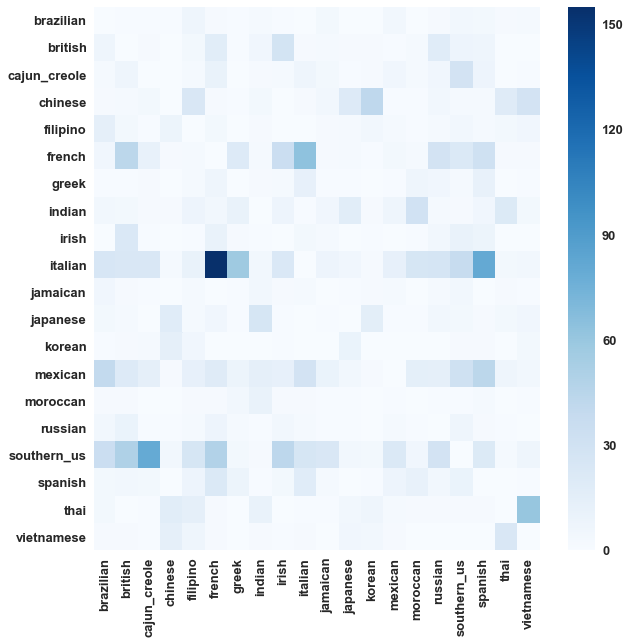

In [396]:
y_pred = broadmatch_pipeline.predict(X_dev_str)
print "Precision of the base model is", precision_score(y_dev, y_pred, average='macro') 
print "Recall of the base model is", recall_score(y_dev, y_pred, average='macro') 

cm = confusion_matrix(y_dev, y_pred)
np.fill_diagonal(cm, 0)
cm_df = pandas.DataFrame(cm, index=broadmatch_pipeline.classes_, columns=broadmatch_pipeline.classes_)

plt.figure(figsize=(10,10))
sn.set(font_scale=1.3)
ax = sn.heatmap(cm_df, cmap="Blues")

## XGBoost Modeling with Hyper-Parameter Tuning

In [429]:
search_params = {
    #'broadmatch__kw_args': [{ "turn_on" : True }, { "turn_on" : False }],
    #'countvectorizer__min_df': np.linspace(5, 100, 5, dtype=int),
    #'countvectorizer__max_df': np.linspace(3000, 10000, 5, dtype=int),
    #'xg__max_depth' : np.linspace(10, 100, 5, dtype=int),
    #'xg__n_estimators' : np.linspace(50, 250, 5, dtype=int),
}


xgboost_pipeline = Pipeline(steps=[
    ('broadmatch', FunctionTransformer(broadmatch_X, validate=False, kw_args={ "turn_on" : False })),
    ('countvectorizer', CountVectorizer(binary=True, max_df = 8250, min_df=5)),
    ('xg', XGBClassifier(nthread=2, max_depth=77, n_estimators=250)),
])

xgboost_pipeline.fit(X_train_str, y_train)

Pipeline(memory=None,
     steps=[('broadmatch', FunctionTransformer(accept_sparse=False,
          func=<function broadmatch_X at 0x1a37d001b8>, inv_kw_args=None,
          inverse_func=None, kw_args={'turn_on': False},
          pass_y='deprecated', validate=False)), ('countvectorizer', CountVectorizer(analyzer=u'word', bin...softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1))])

In [430]:
print "Accuracy of the XGBoost model is", xgboost_pipeline.score(X_dev_str, y_dev)

Accuracy of the XGBoost model is 0.764782783588


## Logistic Regression Modeling with Hyper-Parameter Tuning

In [433]:
search_params = {
    'broadmatch__kw_args': [{ "turn_on" : True }, { "turn_on" : False }],
    'lr__C' : [ 0.1, 1, 10, 100, 1000],
    'lr__multi_class' : ['ovr', 'multinomial'],
    'lr__solver' : ["newton-cg", "lbfgs", "sag", "saga"],
}


lr_pipeline = Pipeline(steps=[
    ('broadmatch', FunctionTransformer(broadmatch_X, validate=False)),
    ('countvectorizer', CountVectorizer(binary=True, max_df = 8250, min_df=5)),
    ('lr', LogisticRegression(n_jobs=2)),
])

grid_search_lr = GridSearchCV(lr_pipeline, search_params, cv=5, verbose=10)
grid_search_lr.fit(X_train_str, y_train)
grid_search_lr.best_params_

Fitting 5 folds for each of 80 candidates, totalling 400 fits
[CV] lr__solver=newton-cg, lr__C=0.1, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr 
[CV]  lr__solver=newton-cg, lr__C=0.1, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr, score=0.710363301524, total=   4.4s
[CV] lr__solver=newton-cg, lr__C=0.1, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.2s remaining:    0.0s


[CV]  lr__solver=newton-cg, lr__C=0.1, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr, score=0.72172893282, total=   4.0s
[CV] lr__solver=newton-cg, lr__C=0.1, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   10.0s remaining:    0.0s


[CV]  lr__solver=newton-cg, lr__C=0.1, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr, score=0.714046262152, total=   4.4s
[CV] lr__solver=newton-cg, lr__C=0.1, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   15.2s remaining:    0.0s


[CV]  lr__solver=newton-cg, lr__C=0.1, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr, score=0.728950016773, total=   4.2s
[CV] lr__solver=newton-cg, lr__C=0.1, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   20.4s remaining:    0.0s


[CV]  lr__solver=newton-cg, lr__C=0.1, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr, score=0.721308724832, total=   3.9s
[CV] lr__solver=lbfgs, lr__C=0.1, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   25.1s remaining:    0.0s


[CV]  lr__solver=lbfgs, lr__C=0.1, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr, score=0.710363301524, total=   3.1s
[CV] lr__solver=lbfgs, lr__C=0.1, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   29.0s remaining:    0.0s


[CV]  lr__solver=lbfgs, lr__C=0.1, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr, score=0.72172893282, total=   3.1s
[CV] lr__solver=lbfgs, lr__C=0.1, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   32.9s remaining:    0.0s


[CV]  lr__solver=lbfgs, lr__C=0.1, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr, score=0.714046262152, total=   3.0s
[CV] lr__solver=lbfgs, lr__C=0.1, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   36.7s remaining:    0.0s


[CV]  lr__solver=lbfgs, lr__C=0.1, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr, score=0.728950016773, total=   3.1s
[CV] lr__solver=lbfgs, lr__C=0.1, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   40.7s remaining:    0.0s


[CV]  lr__solver=lbfgs, lr__C=0.1, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr, score=0.721308724832, total=   3.0s
[CV] lr__solver=sag, lr__C=0.1, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr 
[CV]  lr__solver=sag, lr__C=0.1, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr, score=0.71053072158, total=  35.1s
[CV] lr__solver=sag, lr__C=0.1, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr 
[CV]  lr__solver=sag, lr__C=0.1, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr, score=0.72172893282, total=  35.9s
[CV] lr__solver=sag, lr__C=0.1, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr 
[CV]  lr__solver=sag, lr__C=0.1, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr, score=0.714213878646, total=  36.0s
[CV] lr__solver=sag, lr__C=0.1, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr 
[CV]  lr__solver=sag, lr__C=0.1, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr, score=0.728950016773, t

[CV]  lr__solver=lbfgs, lr__C=1, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr, score=0.743345052737, total=   3.9s
[CV] lr__solver=lbfgs, lr__C=1, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr 
[CV]  lr__solver=lbfgs, lr__C=1, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr, score=0.753727592562, total=   3.6s
[CV] lr__solver=lbfgs, lr__C=1, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr 
[CV]  lr__solver=lbfgs, lr__C=1, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr, score=0.746396245391, total=   3.7s
[CV] lr__solver=lbfgs, lr__C=1, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr 
[CV]  lr__solver=lbfgs, lr__C=1, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr, score=0.762831264676, total=   4.2s
[CV] lr__solver=lbfgs, lr__C=1, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr 
[CV]  lr__solver=lbfgs, lr__C=1, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr, score=0.749832214765, t

[CV]  lr__solver=newton-cg, lr__C=10, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr, score=0.743675657564, total=   5.9s
[CV] lr__solver=newton-cg, lr__C=10, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr 
[CV]  lr__solver=newton-cg, lr__C=10, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr, score=0.739188736172, total=   6.0s
[CV] lr__solver=newton-cg, lr__C=10, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr 
[CV]  lr__solver=newton-cg, lr__C=10, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr, score=0.754444817175, total=   5.8s
[CV] lr__solver=newton-cg, lr__C=10, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr 
[CV]  lr__solver=newton-cg, lr__C=10, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr, score=0.743791946309, total=   6.1s
[CV] lr__solver=lbfgs, lr__C=10, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr 
[CV]  lr__solver=lbfgs, lr__C=10, broadmatch__kw_args={'turn_on': True}, lr__mul

[CV]  lr__solver=saga, lr__C=10, broadmatch__kw_args={'turn_on': True}, lr__multi_class=multinomial, score=0.738350653704, total=   5.1s
[CV] lr__solver=saga, lr__C=10, broadmatch__kw_args={'turn_on': True}, lr__multi_class=multinomial 
[CV]  lr__solver=saga, lr__C=10, broadmatch__kw_args={'turn_on': True}, lr__multi_class=multinomial, score=0.755283461926, total=   5.0s
[CV] lr__solver=saga, lr__C=10, broadmatch__kw_args={'turn_on': True}, lr__multi_class=multinomial 
[CV]  lr__solver=saga, lr__C=10, broadmatch__kw_args={'turn_on': True}, lr__multi_class=multinomial, score=0.740939597315, total=   5.0s
[CV] lr__solver=newton-cg, lr__C=100, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr 
[CV]  lr__solver=newton-cg, lr__C=100, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr, score=0.726435626988, total=   8.7s
[CV] lr__solver=newton-cg, lr__C=100, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr 
[CV]  lr__solver=newton-cg, lr__C=100, broadmatch__kw_args

[CV]  lr__solver=sag, lr__C=100, broadmatch__kw_args={'turn_on': True}, lr__multi_class=multinomial, score=0.737168735324, total=   4.6s
[CV] lr__solver=sag, lr__C=100, broadmatch__kw_args={'turn_on': True}, lr__multi_class=multinomial 
[CV]  lr__solver=sag, lr__C=100, broadmatch__kw_args={'turn_on': True}, lr__multi_class=multinomial, score=0.728859060403, total=   4.8s
[CV] lr__solver=saga, lr__C=100, broadmatch__kw_args={'turn_on': True}, lr__multi_class=multinomial 
[CV]  lr__solver=saga, lr__C=100, broadmatch__kw_args={'turn_on': True}, lr__multi_class=multinomial, score=0.729784028127, total=   5.0s
[CV] lr__solver=saga, lr__C=100, broadmatch__kw_args={'turn_on': True}, lr__multi_class=multinomial 
[CV]  lr__solver=saga, lr__C=100, broadmatch__kw_args={'turn_on': True}, lr__multi_class=multinomial, score=0.728262690568, total=   5.0s
[CV] lr__solver=saga, lr__C=100, broadmatch__kw_args={'turn_on': True}, lr__multi_class=multinomial 
[CV]  lr__solver=saga, lr__C=100, broadmatch__k

[CV]  lr__solver=lbfgs, lr__C=1000, broadmatch__kw_args={'turn_on': True}, lr__multi_class=multinomial, score=0.735826903724, total=   3.6s
[CV] lr__solver=lbfgs, lr__C=1000, broadmatch__kw_args={'turn_on': True}, lr__multi_class=multinomial 
[CV]  lr__solver=lbfgs, lr__C=1000, broadmatch__kw_args={'turn_on': True}, lr__multi_class=multinomial, score=0.726342281879, total=   3.7s
[CV] lr__solver=sag, lr__C=1000, broadmatch__kw_args={'turn_on': True}, lr__multi_class=multinomial 
[CV]  lr__solver=sag, lr__C=1000, broadmatch__kw_args={'turn_on': True}, lr__multi_class=multinomial, score=0.720743345053, total=   4.9s
[CV] lr__solver=sag, lr__C=1000, broadmatch__kw_args={'turn_on': True}, lr__multi_class=multinomial 
[CV]  lr__solver=sag, lr__C=1000, broadmatch__kw_args={'turn_on': True}, lr__multi_class=multinomial, score=0.715530239571, total=   4.8s
[CV] lr__solver=sag, lr__C=1000, broadmatch__kw_args={'turn_on': True}, lr__multi_class=multinomial 
[CV]  lr__solver=sag, lr__C=1000, broa

[CV]  lr__solver=newton-cg, lr__C=0.1, broadmatch__kw_args={'turn_on': False}, lr__multi_class=multinomial, score=0.745469798658, total=   3.8s
[CV] lr__solver=lbfgs, lr__C=0.1, broadmatch__kw_args={'turn_on': False}, lr__multi_class=multinomial 
[CV]  lr__solver=lbfgs, lr__C=0.1, broadmatch__kw_args={'turn_on': False}, lr__multi_class=multinomial, score=0.737652770802, total=   2.9s
[CV] lr__solver=lbfgs, lr__C=0.1, broadmatch__kw_args={'turn_on': False}, lr__multi_class=multinomial 
[CV]  lr__solver=lbfgs, lr__C=0.1, broadmatch__kw_args={'turn_on': False}, lr__multi_class=multinomial, score=0.741330206065, total=   2.8s
[CV] lr__solver=lbfgs, lr__C=0.1, broadmatch__kw_args={'turn_on': False}, lr__multi_class=multinomial 
[CV]  lr__solver=lbfgs, lr__C=0.1, broadmatch__kw_args={'turn_on': False}, lr__multi_class=multinomial, score=0.736004022796, total=   2.9s
[CV] lr__solver=lbfgs, lr__C=0.1, broadmatch__kw_args={'turn_on': False}, lr__multi_class=multinomial 
[CV]  lr__solver=lbfgs, 

[CV]  lr__solver=newton-cg, lr__C=1, broadmatch__kw_args={'turn_on': False}, lr__multi_class=multinomial, score=0.761593838942, total=   5.3s
[CV] lr__solver=newton-cg, lr__C=1, broadmatch__kw_args={'turn_on': False}, lr__multi_class=multinomial 
[CV]  lr__solver=newton-cg, lr__C=1, broadmatch__kw_args={'turn_on': False}, lr__multi_class=multinomial, score=0.768302898308, total=   5.7s
[CV] lr__solver=newton-cg, lr__C=1, broadmatch__kw_args={'turn_on': False}, lr__multi_class=multinomial 
[CV]  lr__solver=newton-cg, lr__C=1, broadmatch__kw_args={'turn_on': False}, lr__multi_class=multinomial, score=0.756620851492, total=   5.2s
[CV] lr__solver=newton-cg, lr__C=1, broadmatch__kw_args={'turn_on': False}, lr__multi_class=multinomial 
[CV]  lr__solver=newton-cg, lr__C=1, broadmatch__kw_args={'turn_on': False}, lr__multi_class=multinomial, score=0.775746393828, total=   5.4s
[CV] lr__solver=newton-cg, lr__C=1, broadmatch__kw_args={'turn_on': False}, lr__multi_class=multinomial 
[CV]  lr__so

[CV]  lr__solver=saga, lr__C=10, broadmatch__kw_args={'turn_on': False}, lr__multi_class=ovr, score=0.76193667281, total=  47.0s
[CV] lr__solver=saga, lr__C=10, broadmatch__kw_args={'turn_on': False}, lr__multi_class=ovr 
[CV]  lr__solver=saga, lr__C=10, broadmatch__kw_args={'turn_on': False}, lr__multi_class=ovr, score=0.757123700972, total=  56.9s
[CV] lr__solver=saga, lr__C=10, broadmatch__kw_args={'turn_on': False}, lr__multi_class=ovr 
[CV]  lr__solver=saga, lr__C=10, broadmatch__kw_args={'turn_on': False}, lr__multi_class=ovr, score=0.772727272727, total=  56.9s
[CV] lr__solver=saga, lr__C=10, broadmatch__kw_args={'turn_on': False}, lr__multi_class=ovr 
[CV]  lr__solver=saga, lr__C=10, broadmatch__kw_args={'turn_on': False}, lr__multi_class=ovr, score=0.768120805369, total=  56.1s
[CV] lr__solver=newton-cg, lr__C=10, broadmatch__kw_args={'turn_on': False}, lr__multi_class=multinomial 
[CV]  lr__solver=newton-cg, lr__C=10, broadmatch__kw_args={'turn_on': False}, lr__multi_class=mu

[CV]  lr__solver=sag, lr__C=100, broadmatch__kw_args={'turn_on': False}, lr__multi_class=ovr, score=0.751047076562, total=  55.6s
[CV] lr__solver=sag, lr__C=100, broadmatch__kw_args={'turn_on': False}, lr__multi_class=ovr 
[CV]  lr__solver=sag, lr__C=100, broadmatch__kw_args={'turn_on': False}, lr__multi_class=ovr, score=0.743211532015, total=  56.4s
[CV] lr__solver=sag, lr__C=100, broadmatch__kw_args={'turn_on': False}, lr__multi_class=ovr 
[CV]  lr__solver=sag, lr__C=100, broadmatch__kw_args={'turn_on': False}, lr__multi_class=ovr, score=0.756457564576, total=  56.6s
[CV] lr__solver=sag, lr__C=100, broadmatch__kw_args={'turn_on': False}, lr__multi_class=ovr 
[CV]  lr__solver=sag, lr__C=100, broadmatch__kw_args={'turn_on': False}, lr__multi_class=ovr, score=0.756543624161, total=  56.2s
[CV] lr__solver=saga, lr__C=100, broadmatch__kw_args={'turn_on': False}, lr__multi_class=ovr 
[CV]  lr__solver=saga, lr__C=100, broadmatch__kw_args={'turn_on': False}, lr__multi_class=ovr, score=0.7565

[CV]  lr__solver=lbfgs, lr__C=1000, broadmatch__kw_args={'turn_on': False}, lr__multi_class=ovr, score=0.699112079075, total=   3.9s
[CV] lr__solver=lbfgs, lr__C=1000, broadmatch__kw_args={'turn_on': False}, lr__multi_class=ovr 
[CV]  lr__solver=lbfgs, lr__C=1000, broadmatch__kw_args={'turn_on': False}, lr__multi_class=ovr, score=0.704994971505, total=   3.9s
[CV] lr__solver=lbfgs, lr__C=1000, broadmatch__kw_args={'turn_on': False}, lr__multi_class=ovr 
[CV]  lr__solver=lbfgs, lr__C=1000, broadmatch__kw_args={'turn_on': False}, lr__multi_class=ovr, score=0.706642066421, total=   3.9s
[CV] lr__solver=lbfgs, lr__C=1000, broadmatch__kw_args={'turn_on': False}, lr__multi_class=ovr 
[CV]  lr__solver=lbfgs, lr__C=1000, broadmatch__kw_args={'turn_on': False}, lr__multi_class=ovr, score=0.710906040268, total=   4.0s
[CV] lr__solver=sag, lr__C=1000, broadmatch__kw_args={'turn_on': False}, lr__multi_class=ovr 
[CV]  lr__solver=sag, lr__C=1000, broadmatch__kw_args={'turn_on': False}, lr__multi_cl

[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed: 124.9min finished


{'broadmatch__kw_args': {'turn_on': False},
 'lr__C': 1,
 'lr__multi_class': 'ovr',
 'lr__solver': 'saga'}

In [434]:
print "Accuracy of the Logistic Regression model is", grid_search_lr.score(X_dev_str, y_dev)

Accuracy of the Logistic Regression model is 0.773230088496


## Evaluation

TBD

## Deployment

Deployment is out of scope of this project, since there is no deployment in the deliverable other than this notebook.

## Scratch

In [149]:
CountVectorizer(broadmatch_X(X_train_str), binary=True)

CountVectorizer(analyzer=u'word', binary=True, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8',
        input=25523                                    peanut salt water
17741    eggs flour baking_soda buttermilk yellow_corn_...
34853    pepper jalapeno_chilies salt oil masa_harina l...
19235    ginger noodle sauce salt water onions fivespic...
22062    rice water soy_sauce scallion ponzu cabbage gi......             water grit milk butter salt heavy_cream
Name: ingredients, Length: 29830, dtype: object,
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [180]:
pd.DataFrame([X_dev_str, y_dev, np.array(y_pred)]).T

,ingredients,cuisine,Unnamed 0
25126,sugar anchovies onions fishcake chilli_paste s...,korean,NaN
3324,English_mustard lobster fish_stock ground_blac...,french,vietnamese
29907,tomatoes lemongrass light_coconut_milk fish_sa...,thai,NaN
38314,potatoes olive_oil_flavored_cooking_spray eggs...,british,NaN
3981,water oil salt baking_powder flour,jamaican,french
29211,diced_green_chilies sour_cream flour shredded_...,mexican,NaN
4557,marsala_wine veal_cutlets low_salt_chicken_bro...,italian,mexican
21340,parmesan_cheese all-purpose_flour squash milk ...,italian,NaN
32188,self_raising_flour water cornflour garlic_salt...,chinese,NaN
4031,sugar corn_oil white_cornmeal self_rising_flou...,southern_us,mexican


In [174]:
y_pred.T

array([u'korean', u'french', u'thai', ..., u'spanish', u'mexican',
       u'french'], dtype=object)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,1,0,9,7,0,4,1,5,3,0,0,15,0,2,9,4,0,2
1,0,0,1,1,2,38,1,7,14,13,1,5,0,2,0,5,46,4,0,0
2,1,7,0,1,1,14,1,2,0,16,1,1,1,9,0,0,58,1,0,0
3,0,1,1,0,7,1,0,5,1,7,1,14,17,5,1,1,15,1,22,12
4,4,2,1,18,0,3,0,1,1,9,1,3,4,7,0,0,17,1,2,3
5,1,9,9,2,8,0,10,2,10,127,0,1,0,8,1,5,52,14,0,0
6,0,1,0,0,1,10,0,5,2,63,0,0,0,5,2,1,11,4,0,0
7,1,4,0,4,5,9,8,0,0,8,0,8,0,11,10,1,7,2,16,2
8,1,20,0,0,1,26,0,1,0,14,1,0,0,1,1,3,35,3,0,1
9,3,10,5,4,8,106,38,7,5,0,1,2,1,25,3,4,43,15,1,0


In [ ]:
pca = PCA()
cv = CountVectorizer(binary=True, min_df=10)
cv = 
pca.fit()